Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 4: Importing and using vector data -- the OGR library
==================================================


## Introduction

The *OGR* library is a companion library to *GDAL* that handles vector data capabilities, including information queryies, file conversions, rasterization of polygon features, polygonization of raster features, and much more. It handles popular formats including the *ESRI Shapefile*, *Keyhole Markup Language*, *PostGIS*, and *SpatiaLite*. For more information on how *OGR* came about and how it relates to *GDAL*, see here: http://trac.osgeo.org/gdal/wiki/FAQGeneral#WhatisthisOGRstuff.

In this tutorial we'll be working with: 
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): `shapely` does things like buffers, unions, intersections, centroids, convex hulls, and lots more.
  * `shapely` is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.
* [Fiona](https://fiona.readthedocs.io/en/latest/): `fiona` does reading and writing data formats.
 * `fiona` is OGR's neat and nimble API for Python programmers. It focuses on reading and writing data in standard Python IO style and relies upon familiar Python types and protocols such as files, dictionaries, mappings, and iterators instead of classes specific to OGR. `fiona` can read and write real-world data using multi-layered GIS formats and zipped virtual file systems and integrates readily with other python GIS packages such as `pyproj`, `Rtree`, and `Shapely`.
* [Descartes](https://bitbucket.org/sgillies/descartes/): a simple library for plotting geometries in `matplotlib`
* [Geopandas](http://geopandas.org/): GeoPandas is an open source project to make working with geospatial data in python easier. 
  * GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.
  * The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.
* [Folium](https://github.com/python-visualization/folium): builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. 
  * Manipulate your data in Python, then visualize it in on a Leaflet map via `folium`. `folium` makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.
  
  
  
Let's explore shapely a bit by creating some shapes:

In [1]:
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon

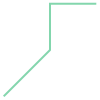

In [2]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

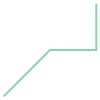

In [3]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

With these two lines created we can run some geospatial operations on them like an intersection:

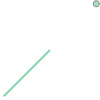

In [4]:
x = b.intersection(a)
x

We can buffer shapes too.

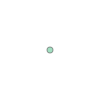

In [5]:
c = Point(1, 1)
c

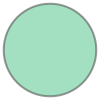

In [6]:
c = c.buffer(1.5)
c

We can do intersections:

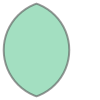

In [7]:
d = Point(2, 1).buffer(1.5)
c.intersection(d)

Or we can do a union instead of an intersection.

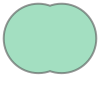

In [8]:
c.union(d)

So far we've just been using the default plotting in Jupyter notebooks. Let's shift now to plotting with matplotlib.

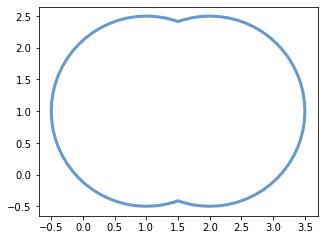

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

BLUE = '#6699cc'
GRAY = '#999999'

fig, ax = plt.subplots(figsize=(5, 5))
x, y = c.union(d).exterior.xy # find all the x and y points in the shape
ax.plot(x, y, color=BLUE, linewidth=3, solid_capstyle='round')
ax.set_aspect('equal') # make the axes equal so the shape isn't distorted
plt.show()

Now let's do something a little more complicated. We're going to plot a line and then buffer around that line in Subplot 1 and then in Subplot 2 we'll plot that buffer and then erode the buffer and plot it on top of the full buffer.

Here we'll use `descartes` to plot these polygon patches in `matplotlib`:

### Using fiona to import shapefiles 

In [11]:
import fiona
# Open the dataset from the file
shapefile = fiona.open('../data/rcr/rcr_landcover.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not shapefile:
    print('Error: could not open shapefile')

With our Shapefile read in, we can look at some of its properties:

In [12]:
### Let's get the driver from this file
driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))

### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile.crs
print('The shapefiles spatial ref is:\n', spatial_ref, '\n')

# Let's pull out a specific feature from the shapefile
feature = shapefile[0]

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

Dataset driver is: ESRI Shapefile

The shapefile has 23 feature(s)

The shapefiles spatial ref is:
 {'init': 'epsg:32618'} 

The features's geometry is: Polygon

Layer has 2 fields
Their names are: 
	Classname
	Classvalue


In [13]:
# you can get a quick view of all of this
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('Classname', 'str:80'),
               ('Classvalue', 'int:18')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:32618'},
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'}

The shapefile is a list of features, which can be accessed like any python list

In [14]:
feature = shapefile[0]
feature # The result is a Python dictionary

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classname', 'Sand'), ('Classvalue', 2253)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(346494.47052450513, 3840484.890103262),
    (346512.1633455531, 3840444.4037230057),
    (346425.2387005355, 3840344.6287597455),
    (346417.20767719497, 3840413.2025623657),
    (346494.47052450513, 3840484.890103262)]]}}

As all dictionaries in Python, there are keys and values.

In [15]:
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [16]:
print('id: ', feature['id']) #gives the id
print('Classname: ', feature['properties']['Classname']) # gives the value of the classname attribute

print('\ngeometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
Classname:  Sand

geometry:  {'type': 'Polygon', 'coordinates': [[(346494.47052450513, 3840484.890103262), (346512.1633455531, 3840444.4037230057), (346425.2387005355, 3840344.6287597455), (346417.20767719497, 3840413.2025623657), (346494.47052450513, 3840484.890103262)]]}


If you want to transform this geometry into a shapely geometry use the shape function that we imported earlier

<class 'shapely.geometry.polygon.Polygon'>


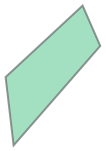

In [17]:
shapely_shape = shape(feature['geometry'])
print(type(shapely_shape))

shapely_shape

We'll come back to this set of training features later!

## Bringing in the real power tools: `geopandas`

Geopandas takes the tools we have seen so far to the next level.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

From the docs:

    GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas Series and DataFrame, respectively.

    A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation.

    A GeoDataFrame is a tabular data structure that contains a GeoSeries.

    The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame‘s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column

Let's show a simple example.

In [18]:
import geopandas as gpd

p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
print(type(g))
g

<class 'geopandas.geoseries.GeoSeries'>


0    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
2    POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....
dtype: geometry

Let's look at a dataset with some more attributes. GeoPandas comes pre-packaged with a `world` dataset that'll do.

In [22]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

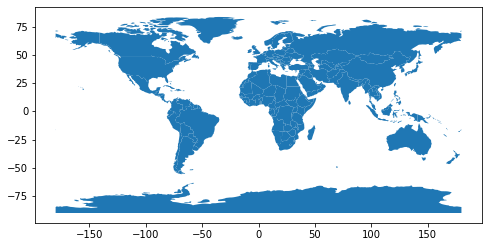

In [23]:
fig, ax = plt.subplots(figsize=(8,8)) 
world.plot(ax=ax)

With geopandas you can do filtering just like in any pandas dataframe

In [24]:
# find all countries with a population greater than 150 million
world[(world.pop_est > 150000000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."
56,190632261,Africa,Nigeria,NGA,1089000.0,"POLYGON ((2.69170 6.25882, 2.74906 7.87073, 2...."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."
99,157826578,Asia,Bangladesh,BGD,628400.0,"POLYGON ((92.67272 22.04124, 92.65226 21.32405..."
102,204924861,Asia,Pakistan,PAK,988200.0,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."
139,1379302771,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ..."


We can filter all latitudes greater than 0 leaving only the southern hemisphere

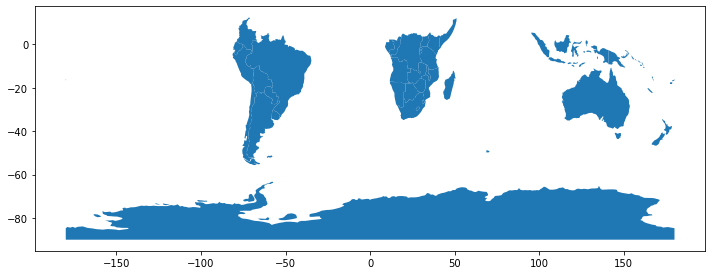

In [25]:
southern_world = world.cx[:, :0]

fig, ax = plt.subplots(figsize=(12,5)) 
southern_world.plot(ax=ax);

We can do more advanced filtering like combining the countries from each continent and then sorting continents by population.

In [26]:
world_filtered = world[['continent', 'geometry', 'pop_est']] # filter to only the columns we care about
continents = world_filtered.dissolve(by='continent', aggfunc='sum') # dissolve countries
continents

,geometry,pop_est
continent,,
Africa,"MULTIPOLYGON (((40.437 -11.762, 40.561 -12.639...",1219176238
Antarctica,"MULTIPOLYGON (((-61.139 -79.981, -60.610 -79.6...",4050
Asia,"MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...",4389144868
Europe,"MULTIPOLYGON (((-53.779 2.377, -54.088 2.106, ...",746398461
North America,"MULTIPOLYGON (((-78.215 7.512, -78.429 8.052, ...",573042112
Oceania,"MULTIPOLYGON (((171.949 -41.514, 172.097 -40.9...",36782844
Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...",140
South America,"MULTIPOLYGON (((-57.750 -51.550, -58.050 -51.9...",418540749


It is also really simple to create Chloropleth maps (maps where the color of each shape is based on the value of an
associated variable). 

Simply use the plot command with the column argument set to the column whose values you want used to assign colors.

Let's calculate and plot by GDP per capita

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

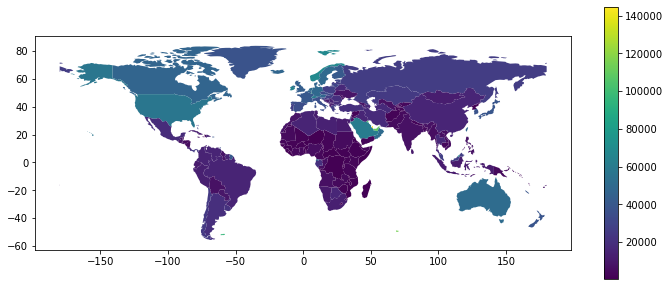

In [27]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world['gdp_per_cap'] = world['gdp_per_cap'] * 1000000 # because it was calcualted in millionths

fig, ax = plt.subplots(figsize=(12,5))
world.plot(column='gdp_per_cap', legend=True, ax=ax) # let's also add a colorbar

Let's take a look at some ocean and glacier data

<AxesSubplot:>

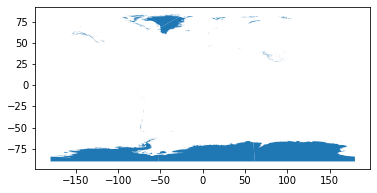

In [28]:
# load in the data
# data available from http://www.naturalearthdata.com/downloads/
glaciers = gpd.read_file("../data/shapefiles/ne_10m_glaciated_areas.shp")
glaciers.plot()

<AxesSubplot:>

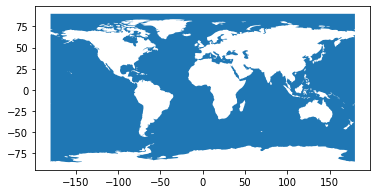

In [29]:
# data available from http://www.naturalearthdata.com/downloads/
oceans = gpd.read_file("../data/shapefiles/ne_110m_ocean.shp")
oceans.plot()

Let's overlay the oceans, countries, and glaciers

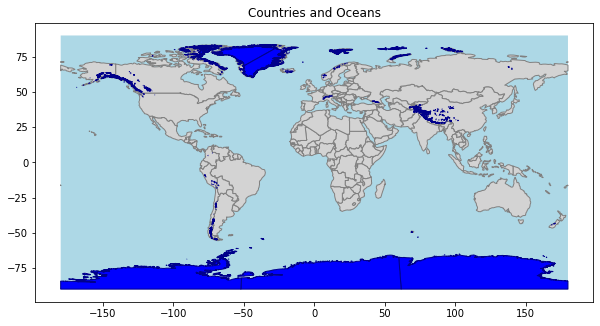

In [30]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_aspect('equal')

Let's look at Anchorage Alaska at 61.2181° N, 149.9003° W

Note there are some mismatches between the glacier and land datasets because of the different resolutions

(-155.0, -145.0)

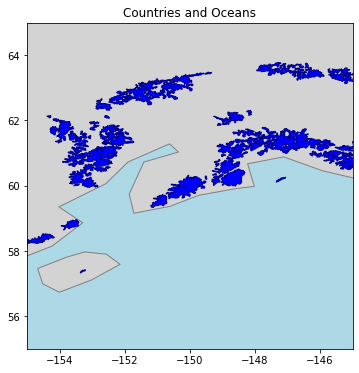

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')

# specify a location by lat and long
ax.set_ylim([55, 65])
ax.set_xlim([-155, -145])

# Now let's combine this new vector knowledge with our raster dataset

### For now, let's visualize our raster and shapefile datasets together

In [32]:
import rasterio
import numpy as np
dataset = rasterio.open('../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff')

Read our shapefile straight into a geopandas GeoDataFrame

In [33]:
shapefile = gpd.read_file('../data/rcr/rcr_landcover.shp')
shapefile.head()

,Classname,Classvalue,geometry
0,Sand,2253,"POLYGON ((346494.471 3840484.890, 346512.163 3..."
1,Forested Wetland,2360,"POLYGON ((347156.620 3842382.623, 347140.569 3..."
2,Forested Wetland,2360,"POLYGON ((347374.249 3842272.855, 347343.280 3..."
3,Sand,2253,"POLYGON ((347752.940 3842285.305, 347732.080 3..."
4,Emergent Wetland,2260,"POLYGON ((352462.707 3840569.388, 352421.826 3..."


We could filter the DF down to the columns we care about if we wanted to:

In [34]:
shapefile_filtered = shapefile.filter(['Classname', 'geometry'])
shapefile_filtered.head()

,Classname,geometry
0,Sand,"POLYGON ((346494.471 3840484.890, 346512.163 3..."
1,Forested Wetland,"POLYGON ((347156.620 3842382.623, 347140.569 3..."
2,Forested Wetland,"POLYGON ((347374.249 3842272.855, 347343.280 3..."
3,Sand,"POLYGON ((347752.940 3842285.305, 347732.080 3..."
4,Emergent Wetland,"POLYGON ((352462.707 3840569.388, 352421.826 3..."


#### Okay now let's try to find the bounding box of the raster and visualize it

These look like lat lon coordinates but let's make sure:

In [35]:
dataset.crs

CRS.from_epsg(4326)

Not very human readable... let's use pyproj to make sure:

In [36]:
from pyproj import CRS

CRS(dataset.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now let's check our shapefile crs:

In [37]:
shapefile.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
CRS(shapefile.crs)

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

They are different! 

We could project the shapefile to lat long or we could change the raster to `epsg:32618` which is UTM 18N. For now since, we are only worried about the raster bounds, we'll change the crs of those four points to UTM 18N.

Let's find all four corner points by using `dataset.transform * (<pixel location>)` which allows you to input a pixel location and returns a coordinate pair in the current CRS:

In [39]:
from pyproj import Transformer
from pyproj import Proj

# this will get our four corner points
raster_gps_points = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(dataset.crs) # our current crs
p2 = Proj(shapefile.crs) # the crs we want our raster to be in
# we could also specifc UTM 18N as:
#   p2 = Proj("+proj=utm +zone=18, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# use the pyproj Transformer.transform function to convert the positions to longs, lats
transformer = Transformer.from_crs(p1.crs, p2.crs)
UTMx, UTMy = transformer.transform(np.array(raster_gps_points)[:,1],np.array(raster_gps_points)[:,0])

raster_utm_points = list(zip(UTMx, UTMy)) # zip up the points so they're in the form [(lat, long), ...]

print('raster bounds in UTM 18N:\n', raster_utm_points, '\n')
print('raster bounds in lat, lon:\n', raster_gps_points)

raster bounds in UTM 18N:
 [(342874.29359233467, 3844458.611782608), (364501.9870325172, 3844114.8502116846), (364236.96553226013, 3826072.8217074675), (342566.93812409707, 3826415.843995134)] 

raster bounds in lat, lon:
 ((-76.716188, 34.730144), (-76.479982, 34.730144), (-76.479982, 34.567461), (-76.716188, 34.567461))


Great now we've got our raster bounds and shapefile in matching coordinate reference systems!

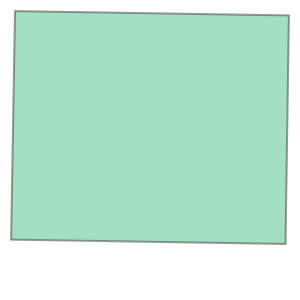

In [40]:
# we can make a simple Shapely shape out of these bounds if we want
raster_geometry = {
    'type' : 'Polygon',
    'coordinates' : [list(raster_utm_points)]     
         }
raster_shape = shape(raster_geometry)
raster_shape

# let's make it interactive and add some class labels

Again you may've installed these two packges in chapter 2, but just in case not let's run it here:

In [ ]:
! pip install folium==0.12.1

     |████████████████████████████████| 94 kB 527 kB/s eta 0:00:01


In [44]:
! pip install geojson==2.5.0

In [45]:
import folium # let's make an interactive map using leaflet

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
raster_gps_reversed = list(zip(np.array(raster_gps_points)[:,1], np.array(raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=11) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Sentinel-2 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

# there may be a more efficient way to add these, need to check recent folium updates
for index in range(0, len(shapefile)):
    # pick out each feature by its index
    feat = shapefile.iloc[index]
    feat_geom = shape(feat['geometry'])
    feat_name = feat['Classname']
    
    # have to do error catching because .exterior.xy doesn't work for multipart polygons
    try:
        # again use Pyproj to reproject the crs now in the opposite direction
        p1 = Proj(shapefile.crs)
        p2 = Proj(dataset.crs) # we want to display on folium using WGS84
        # we could also do
        #    p2 = Proj(proj='latlong',datum='WGS84') # we want to display on folium using WGS84
        # use the pyproj Transformer.transform function to convert the positions to longs, lats
        transformer = Transformer.from_crs(p1.crs, p2.crs)
        lats, longs = transformer.transform(feat_geom.exterior.xy[0], feat_geom.exterior.xy[1])
        gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

        folium.Polygon(gps_points, 
                   tooltip=feat_name, 
                   color='#000000',
                   fill=True,
                   fill_color='#99999'
                      ).add_to(m)
    except AttributeError:
        pass

m

### Now that is actually useful for exploring the dataset!

## Wrapup

Now that we have all these tools in our toolkit, we can proceed to use them for pairing our labeled polygons with the matching pixels in our Planet image to train a classifier for image classification. We continue this step in the next chapter (link to [webpage](chapter_5_classification.html) or [Notebook](chapter_5_classification.ipynb)).

For more visualization goodies I strongly suggest checking out some of the following:
- `Geoplot`
  - Docs here: https://residentmario.github.io/geoplot/index.html  
  - Integration with `Geopandas` here: http://geopandas.org/gallery/plotting_with_geoplot.html#sphx-glr-gallery-plotting-with-geoplot-py
  
---